In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import neurogym as ngym
import logging
import warnings
from EI_network import EINet
from LeakyRNNNet import RNNNet
import torch.optim as optim
import matplotlib.pyplot as plt

c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\pyparsing\core.py:23: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\envs\registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


Initalise the dataset 1

c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\utils\passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\utils\passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Input size: 3, Output size: 3


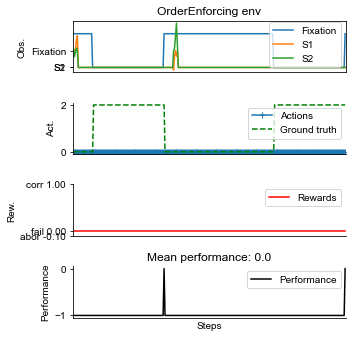

In [ ]:
#Dataset loading 
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Environment
task = 'PerceptualDecisionMakingDelayResponse-v0'
#task = 'PerceptualDecisionMaking-v0'


timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100


seq_len = 100
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16, seq_len=seq_len)

env = dataset.env

ngym.utils.plot_env(env, num_trials=2, def_act=0, ob_traces=["Fixation", "S1", "S2"])

# Get input and output sizes
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

print(f"Input size: {input_size}, Output size: {output_size}")

In [3]:
ob1, gt1 = env.ob, env.gt

print(ob1,gt1)

indices_1 = np.where(ob1[:, 0] == 1)[0]

indices_0 = np.where(ob1[:, 0] == 0)[0]

indices_gt_1 = np.where(gt1 == 1)

print("Indices where first column is 1:", indices_1)
print("Indices where first column is 0:", indices_0)
print('For the gt',indices_gt_1)

[[ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.6109156  -0.1876244 ]
 [ 1.          0.71040946  0.03703934]
 [ 1.          0.94013125  0.14061733]
 [ 1.          0.53389245  0.31693035]
 [ 1.          0.69410634 -0.3299999 ]
 [ 1.          1.0978345   0.23331289]
 [ 1.          0.8830096   0.18016197]
 [ 1.          1.0123323   0.39911848]
 [ 1.          1.0678248   0.4622696 ]
 [ 1.          0.7111582   0.50300765]
 [ 1.          1.0780939   0.08803151]
 [ 1.          0.8738193   0.43298134]
 [ 1.          0.96107167 -0.02269805]
 [ 1.          0.34388506  0.17428276]
 [ 1.          0.765733    0.22401495]
 [ 1.          0.8656006 

In [4]:
class TransferLearningWrapper(nn.Module):
    def __init__(self, base_model, e_prop, hidden_size, new_output_size):
        super(TransferLearningWrapper, self).__init__()
        self.base_model = base_model 
        
        for param in self.base_model.parameters():
            param.requires_grad = True

        for name, param in self.base_model.named_parameters():
            if "fc" in name:  
                param.requires_grad = True  

    def forward(self, x):
        return self.base_model(x)

In [5]:
#EI net and LeakyRNN model initialisation, the number of parameter is fixed  
hidden_size = 50
e_prop = 0.8
EI_RNN_pre = EINet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, e_prop=e_prop, sigma_rec=0.15)
print(EI_RNN_pre)

Leaky_RNN_pre = RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, e_prop=e_prop)
print(Leaky_RNN_pre)

print("Parameters of EI_RNN_pre:")
for name, param in EI_RNN_pre.named_parameters():
    print(f"{name}: {param.shape}")

print("\nParameters of Leaky_RNN_pre:")
for name, param in Leaky_RNN_pre.named_parameters():
    print(f"{name}: {param.shape}")




EINet(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Parameters of EI_RNN_pre:
rnn.input2h.weight: torch.Size([50, 3])
rnn.input2h.bias: torch.Size([50])
rnn.h2h.weight: torch.Size([50, 50])
rnn.h2h.bias: torch.Size([50])
fc.weight: torch.Size([3, 40])
fc.bias: torch.Size([3])

Parameters of Leaky_RNN_pre:
rnn.input2h.weight: torch.Size([50, 3])
rnn.input2h.bias: torch.Size([50])
rnn.h2h.weight: torch.Size([50, 50])
rnn.h2h.bias: torch.Size([50])
fc.weight: torch.Size([3, 40])
fc.bias: torch.Size([3])


In [6]:
#load parameter
EI_model_parameter = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\model_parameter\EI_RNN_model_task1.tar"
Leaky_model_parameter = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\model_parameter\Leaky_RNN_model_task1.tar"

EI_checkpoint = torch.load(EI_model_parameter)  
EI_RNN_pre.load_state_dict(EI_checkpoint['model_state_dict']) 
Leaky_checkpoint = torch.load(Leaky_model_parameter)
Leaky_RNN_pre.load_state_dict(Leaky_checkpoint['model_state_dict'])

EI_RNN = TransferLearningWrapper(base_model=EI_RNN_pre, e_prop = 0.8,hidden_size=50, new_output_size=3)
Leaky_RNN = TransferLearningWrapper(base_model=Leaky_RNN_pre,e_prop = 0.8,hidden_size=50, new_output_size=3)

In [7]:
#check if the last FC layer is indeed have gradient being enabled
print("parameters grad in EI_RNN transfer:")
for name, param in EI_RNN.named_parameters():
    print(f"{name}: {param.shape}, requires_grad={param.requires_grad}")

print("parameters grad in Leaky_RNN transfer:")
for name, param in Leaky_RNN.named_parameters():
    print(f"{name}: {param.shape}, requires_grad={param.requires_grad}")

parameters grad in EI_RNN transfer:
base_model.rnn.input2h.weight: torch.Size([50, 3]), requires_grad=True
base_model.rnn.input2h.bias: torch.Size([50]), requires_grad=True
base_model.rnn.h2h.weight: torch.Size([50, 50]), requires_grad=True
base_model.rnn.h2h.bias: torch.Size([50]), requires_grad=True
base_model.fc.weight: torch.Size([3, 40]), requires_grad=True
base_model.fc.bias: torch.Size([3]), requires_grad=True
parameters grad in Leaky_RNN transfer:
base_model.rnn.input2h.weight: torch.Size([50, 3]), requires_grad=True
base_model.rnn.input2h.bias: torch.Size([50]), requires_grad=True
base_model.rnn.h2h.weight: torch.Size([50, 50]), requires_grad=True
base_model.rnn.h2h.bias: torch.Size([50]), requires_grad=True
base_model.fc.weight: torch.Size([3, 40]), requires_grad=True
base_model.fc.bias: torch.Size([3]), requires_grad=True


In [ ]:
optimizer_EI_RNN = optim.Adam(filter(lambda p: p.requires_grad, EI_RNN.parameters()), lr=0.0001)
criterion = nn.CrossEntropyLoss()

loss_values = []  
running_loss_EI_RNN = 0.0
print_step = 2

for i in range(100):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer_EI_RNN.zero_grad()

    # Forward pass
    output, activity = EI_RNN(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer_EI_RNN.step()

    # Update running loss
    running_loss_EI_RNN += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_EI_RNN / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  
        running_loss_EI_RNN = 0.0

torch.save({
    'model_state_dict': EI_RNN.state_dict(),
    'optimizer_state_dict': optimizer_EI_RNN.state_dict(),
    'loss_values': loss_values,  
}, 'EI_RNN_model_task3.tar')

print("Model and optimizer state saved in EI_RNN_model_task3.tar")

Step 2, Loss 0.4239
Step 4, Loss 0.5618
Step 6, Loss 0.4619
Step 8, Loss 0.4029
Step 10, Loss 0.4389
Step 12, Loss 0.4788
Step 14, Loss 0.4678
Step 16, Loss 0.3565
Step 18, Loss 0.4943
Step 20, Loss 0.3976
Step 22, Loss 0.4595
Step 24, Loss 0.3376
Step 26, Loss 0.5345
Step 28, Loss 0.2992
Step 30, Loss 0.3352
Step 32, Loss 0.2544
Step 34, Loss 0.4053
Step 36, Loss 0.3299
Step 38, Loss 0.3645
Step 40, Loss 0.3361
Step 42, Loss 0.3542
Step 44, Loss 0.3387
Step 46, Loss 0.3104
Step 48, Loss 0.4408
Step 50, Loss 0.3262
Step 52, Loss 0.3489
Step 54, Loss 0.3378
Step 56, Loss 0.3704
Step 58, Loss 0.2889
Step 60, Loss 0.3173
Step 62, Loss 0.2526
Step 64, Loss 0.3734
Step 66, Loss 0.3656
Step 68, Loss 0.3609
Step 70, Loss 0.3523
Step 72, Loss 0.3314
Step 74, Loss 0.3235
Step 76, Loss 0.3137
Step 78, Loss 0.3259
Step 80, Loss 0.3388
Step 82, Loss 0.3261
Step 84, Loss 0.3219
Step 86, Loss 0.3502
Step 88, Loss 0.2888
Step 90, Loss 0.3177
Step 92, Loss 0.1717
Step 94, Loss 0.3281
Step 96, Loss 0.3

In [ ]:
# Train the Leaky

optimizer_Leaky_RNN = optim.Adam(filter(lambda p: p.requires_grad, Leaky_RNN.parameters()), lr=0.0001)
criterion = nn.CrossEntropyLoss()

Leaky_RNN_loss_values = []  
running_loss_Leaky_RNN = 0.0
print_step = 2

for i in range(100):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer_Leaky_RNN.zero_grad()

    # Forward pass
    output, activity,_ = Leaky_RNN(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer_Leaky_RNN.step()

    # Update running loss
    running_loss_Leaky_RNN += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_Leaky_RNN / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        Leaky_RNN_loss_values.append(average_loss)  
        running_loss_Leaky_RNN = 0.0

torch.save({
    'model_state_dict': Leaky_RNN.state_dict(),
    'optimizer_state_dict': optimizer_Leaky_RNN.state_dict(),
    'loss_values': Leaky_RNN_loss_values,  
}, 'Leaky_RNN_model_task3.tar')

print("Model and optimizer state saved in Leaky_RNN_model_task3.tar")

Step 2, Loss 1.5387
Step 4, Loss 1.5133
Step 6, Loss 0.7851
Step 8, Loss 1.3713
Step 10, Loss 1.3129
Step 12, Loss 1.0587
Step 14, Loss 1.1102
Step 16, Loss 0.7887
Step 18, Loss 1.0636
Step 20, Loss 0.7317
Step 22, Loss 0.6287
Step 24, Loss 0.5875
Step 26, Loss 0.7602
Step 28, Loss 0.8159
Step 30, Loss 0.6987
Step 32, Loss 0.5893
Step 34, Loss 0.4463
Step 36, Loss 0.3985
Step 38, Loss 0.5131
Step 40, Loss 0.4733
Step 42, Loss 0.4602
Step 44, Loss 0.4242
Step 46, Loss 0.4230
Step 48, Loss 0.4397
Step 50, Loss 0.3909
Step 52, Loss 0.2751
Step 54, Loss 0.4127
Step 56, Loss 0.4142
Step 58, Loss 0.3571
Step 60, Loss 0.3996
Step 62, Loss 0.3470
Step 64, Loss 0.3653
Step 66, Loss 0.3129
Step 68, Loss 0.3492
Step 70, Loss 0.3767
Step 72, Loss 0.3511
Step 74, Loss 0.3889
Step 76, Loss 0.3632
Step 78, Loss 0.3273
Step 80, Loss 0.3261
Step 82, Loss 0.2451
Step 84, Loss 0.3106
Step 86, Loss 0.3139
Step 88, Loss 0.3748
Step 90, Loss 0.3391
Step 92, Loss 0.3468
Step 94, Loss 0.3405
Step 96, Loss 0.2

50
50


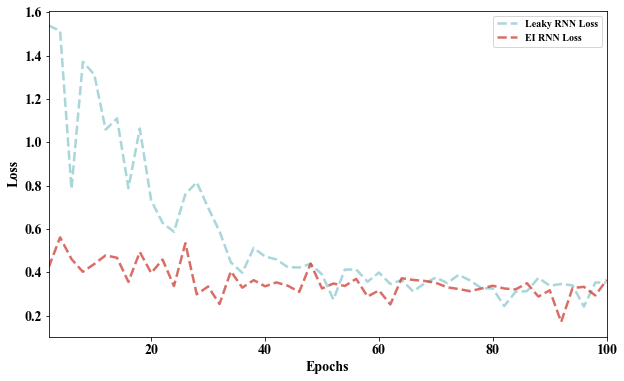

In [ ]:
print(len(Leaky_RNN_loss_values))
print(len(loss_values))

epoch = np.linspace(2, 100,len(Leaky_RNN_loss_values))

plt.figure(figsize=(10, 6))
plt.plot(epoch, Leaky_RNN_loss_values, label='Leaky RNN Loss', linewidth=2.5, color='#84c5cb', linestyle='--', alpha=0.7)
plt.plot(epoch, loss_values, label='EI RNN Loss', linewidth=2.5, color='#cb3127', linestyle='--', alpha=0.7)

plt.xlabel('Epochs', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel('Loss', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
plt.legend(fontsize=14, loc='upper right', prop={'weight': 'bold', 'family': 'Times New Roman'})
plt.xticks(fontsize=14, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=14, fontweight='bold', fontfamily='Times New Roman')
plt.grid(False)
plt.xlim([2, 100])


save_path = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\loss_plot_task3.png"
plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()

Starting analysising the network 

In [ ]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500),})

num_trial = 5000
#num_trial = 2
# EI_RNN net execution
ei_perf = 0
ei_activity_dict = {}
ei_trial_infos = {}
ei_stim_activity = [[], []] 
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    #print(ob.shape)
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    ei_action_pred, ei_rnn_activity = EI_RNN(inputs) 
    #print(ei_rnn_activity.shape)
    # Compute performance for EI_RNN
    ei_action_pred = ei_action_pred.detach().numpy()
    ei_choice = np.argmax(ei_action_pred[-1, 0, :])
    print(ei_choice)
    #print(gt[-1])
    ei_correct = ei_choice == gt[-1]

    # Log trial info for EI_RNN
    ei_trial_info = env.trial
    ei_trial_info.update({'correct': ei_correct, 'choice': ei_choice})
    ei_trial_infos[i] = ei_trial_info

    # Log stimulus period activity for EI_RNN
    
    ei_rnn_activity = ei_rnn_activity[:, 0, :].detach().numpy()
    
    ei_activity_dict[i] = ei_rnn_activity
    #print(f"Trial {i}: Ground truth value = {env.trial['ground_truth']}")
    # Compute stimulus selectivity for EI_RNN
    ei_rnn_activity = ei_rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    ei_stim_activity[env.trial['ground_truth']-1].append(ei_rnn_activity) 

print('Average performance for EI_RNN:', np.mean([val['correct'] for val in ei_trial_infos.values()]))


1
1
2
1
2
1
1
1
1
2
2
1
1
1
2
2
2
1
1
1
1
1
2
1
2
2
1
1
2
1
2
2
1
1
2
1
1
1
1
1
1
2
2
2
1
1
2
2
2
2
1
2
1
1
1
2
2
1
2
1
1
2
1
1
1
1
1
1
2
2
2
1
1
2
1
1
2
2
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
2
2
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
2
2
2
2
2
1
1
1
1
1
2
2
1
2
1
2
2
1
2
2
1
2
2
1
1
2
1
2
2
2
2
1
2
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
2
2
1
1
1
1
2
2
1
2
2
2
1
2
1
2
2
2
1
1
1
1
2
1
2
2
1
2
1
2
1
1
1
1
2
1
2
2
2
1
1
1
2
2
2
2
2
1
2
1
1
2
2
1
1
1
1
2
1
1
2
1
1
1
2
2
1
2
1
1
1
2
1
1
1
2
1
1
1
1
2
1
2
2
2
2
2
1
1
1
2
2
1
2
2
1
2
1
1
1
1
1
2
2
1
1
2
1
2
1
1
1
1
1
2
1
2
2
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
1
1
2
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
2
1
2
1
2
1
1
1
1
1
1
1
2
1
1
2
2
1
2
2
1
2
2
2
1
2
2
2
1
2
1
1
1
1
1
1
2
1
1
1
1
2
2
1
1
2
1
1
1
1
1
1
1
2
2
1
1
1
2
2
2
2
1
2
1
2
1
1
1
1
1
2
1
1
1
2
2
2
1
2
2
1
1
2
1
1
1
1
1
2
1
1
1
1
2
1
1
2
1
2
1
1
1
2
1
1
2
1
2
1
2
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
2
2
1
2
1
2
2
1
1
1
1
1
2
1
2
1
1
2
1
1
1


In [ ]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})


leaky_perf = 0
leaky_activity_dict = {}
leaky_trial_infos = {}
leaky_stim_activity = [[], []]  
num_trial = 5000
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    leaky_action_pred, leaky_rnn_activity, pool_hidden_test = Leaky_RNN(inputs)  

    # Compute performance for Leaky_RNN
    leaky_action_pred = leaky_action_pred.detach().numpy()
    leaky_choice = np.argmax(leaky_action_pred[-1, 0, :])
    print(leaky_choice)
    leaky_correct = leaky_choice == gt[-1]

    # Log trial info for Leaky_RNN
    leaky_trial_info = env.trial
    leaky_trial_info.update({'correct': leaky_correct, 'choice': leaky_choice})
    leaky_trial_infos[i] = leaky_trial_info

    # Log stimulus period activity for Leaky_RNN
    leaky_rnn_activity = leaky_rnn_activity[:, 0, :].detach().numpy()
    leaky_activity_dict[i] = leaky_rnn_activity

    # Compute stimulus selectivity for Leaky_RNN
    leaky_rnn_activity = leaky_rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]  
    leaky_stim_activity[env.trial['ground_truth']-1].append(leaky_rnn_activity)

print('Average performance for Leaky_RNN:', np.mean([val['correct'] for val in leaky_trial_infos.values()]))

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


Processing EI_RNN...


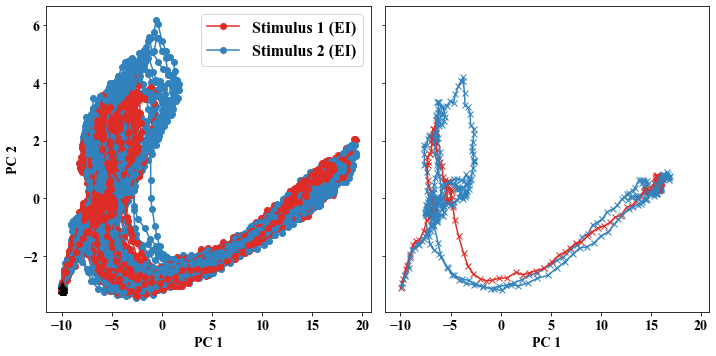

In [ ]:

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500 
plot_until_time = 1000 # Basically plot all 

print("Processing EI_RNN...")
ei_activity = np.concatenate([ei_activity_dict[i] for i in range(num_trial)], axis=0)

ei_pca = PCA(n_components=2)
ei_pca.fit(ei_activity)  
ei_activity_pc = ei_pca.transform(ei_activity)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for i in range(100):
    ei_activity_pc = ei_pca.transform(ei_activity_dict[i])
    
    trial = ei_trial_infos[i]
    #print(trial['ground_truth'])
    color = '#de2d26' if trial['ground_truth'] == 1 else '#3182bd'

    ax1.plot(ei_activity_pc[:plot_until_time, 0], ei_activity_pc[:plot_until_time, 1], 'o-', color=color, label='Stimulus 1 (EI)' if trial['ground_truth'] == 1 else 'Stimulus 2 (EI)')
    
    if i < 3:

        ax2.plot(ei_activity_pc[:plot_until_time, 0], ei_activity_pc[:plot_until_time, 1], 'x-', color=color)

    ax1.plot(ei_activity_pc[0, 0], ei_activity_pc[0, 1], '^', color='black')


handles, labels = ax1.get_legend_handles_labels()



unique_handles_labels = dict(zip(labels, handles))  

ordered_labels = ['Stimulus 1 (EI)', 'Stimulus 2 (EI)']
ordered_handles = [unique_handles_labels[label] for label in ordered_labels]

ax1.legend(ordered_handles, ordered_labels, loc='best', 
           fontsize=14, frameon=True, prop={'weight': 'bold', 'size': 16, 'family': 'Times New Roman'})



ax1.set_xlabel('PC 1', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax1.set_ylabel('PC 2', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax2.set_xlabel('PC 1', fontsize=14, fontweight='bold', fontfamily='Times New Roman')


plt.tight_layout()
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')


save_path = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task3_plot_a_PCA.png"
plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Processing EI_RNN...


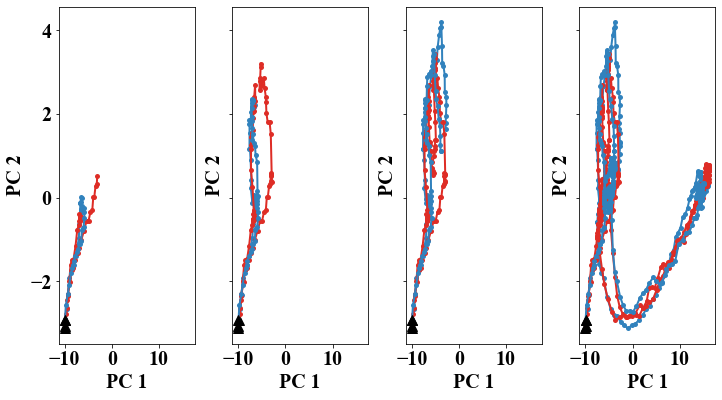

In [ ]:
import logging
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500 
plot_until_time = 10000  # Basically plot all

print("Processing EI_RNN...")
ei_activity = np.concatenate([ei_activity_dict[i] for i in range(num_trial)], axis=0)

ei_pca = PCA(n_components=2)
ei_pca.fit(ei_activity)  
ei_activity_pc = ei_pca.transform(ei_activity)

time_intervals = [20, 40, 60,-1]

fig, axs = plt.subplots(1, 4, figsize=(10, 6), sharex=True, sharey=True)  

plot_indices = [0,1,5,10]
#plot_indices = [0, 1, 2, 15]

for ax, time_end in zip(axs, time_intervals):
    for i in plot_indices: 
        ei_activity_pc = ei_pca.transform(ei_activity_dict[i])

        trial = ei_trial_infos[i]
        color = '#de2d26' if trial['ground_truth'] == 1 else '#3182bd'

        ax.plot(ei_activity_pc[:time_end, 0], ei_activity_pc[:time_end, 1], 'o-', color=color, linewidth=2,markersize=2, markeredgewidth=3)
        ax.plot(ei_activity_pc[0, 0], ei_activity_pc[0, 1], '^', color='k', markersize=10)  

    ax.set_xlabel('PC 1', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
    ax.set_ylabel('PC 2', fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')


#save_path = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task2_plot_b_PCA.png"
#plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Processing Leaky_RNN...
Leaky_RNN Neural Activity Shape: (100920, 50)
Leaky_RNN Projected Activity Shape: (100920, 2)


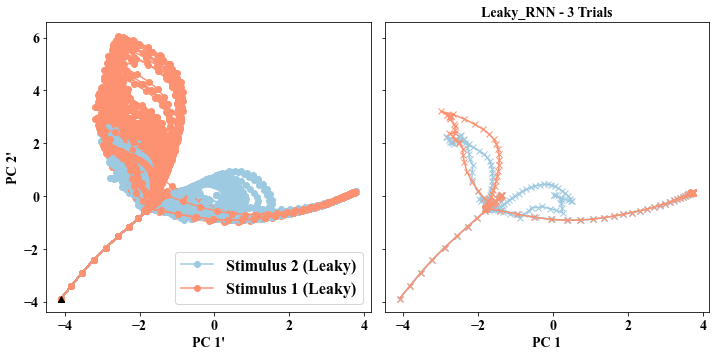

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500 
plot_until_time = 500  # Basically plot all 

print("Processing Leaky_RNN...")
leaky_activity_all = np.concatenate([leaky_activity_dict[i] for i in range(num_trial)], axis=0)
print('Leaky_RNN Neural Activity Shape:', leaky_activity_all.shape)

leaky_pca_model = PCA(n_components=2)
leaky_pca_model.fit(leaky_activity_all)
leaky_activity_projected = leaky_pca_model.transform(leaky_activity_all)
print('Leaky_RNN Projected Activity Shape:', leaky_activity_projected.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for i in range(100):
    leaky_activity_per_trial = leaky_pca_model.transform(leaky_activity_dict[i])
    trial_info = leaky_trial_infos[i]
    color = '#fc9272' if trial_info['ground_truth'] == 1 else '#9ecae1'


    ax1.plot(leaky_activity_per_trial[:plot_until_time, 0], leaky_activity_per_trial[:plot_until_time, 1], 
             'o-', color=color, label='Stimulus 1 (Leaky)' if trial_info['ground_truth'] == 1 else 'Stimulus 2 (Leaky)')
    
    if i < 3:
        ax2.plot(leaky_activity_per_trial[:plot_until_time, 0], leaky_activity_per_trial[:plot_until_time, 1], 
                 'x-', color=color)

    # Mark the starting point
    ax1.plot(leaky_activity_per_trial[0, 0], leaky_activity_per_trial[0, 1], '^', color='black')


handles, labels = ax1.get_legend_handles_labels()

unique_handles_labels = dict(zip(labels, handles))  
ax1.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='best', 
           fontsize=14, frameon=True, prop={'weight': 'bold', 'size': 16, 'family': 'Times New Roman'})


ax2.set_title('Leaky_RNN - 3 Trials', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax1.set_xlabel("PC 1'", fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax1.set_ylabel("PC 2'", fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax2.set_xlabel('PC 1', fontsize=14, fontweight='bold', fontfamily='Times New Roman')

plt.tight_layout()
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task3_plot_a_PCA.png"
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Processing Leaky_RNN...


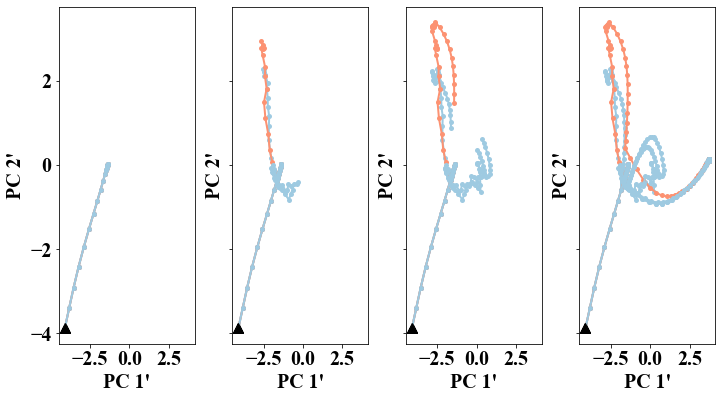

In [ ]:
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  
plot_until_time = 300  # Basically plot all


print("Processing Leaky_RNN...")
leaky_activity = np.concatenate([leaky_activity_dict[i] for i in range(num_trial)], axis=0)

leaky_pca = PCA(n_components=2)
leaky_pca.fit(leaky_activity)  
leaky_activity_pc = leaky_pca.transform(leaky_activity)

time_intervals = [20, 40, 60,-1]

fig, axs = plt.subplots(1, 4, figsize=(10, 6), sharex=True, sharey=True)  

plot_indices = [0,1,8,9] 

for ax, time_end in zip(axs, time_intervals):
    for i in plot_indices:  
        leaky_activity_pc = leaky_pca.transform(leaky_activity_dict[i])

        trial = leaky_trial_infos[i]
        color = '#fc9272' if trial['ground_truth'] == 1 else '#9ecae1' 

        ax.plot(leaky_activity_pc[:time_end, 0], leaky_activity_pc[:time_end, 1], 
                'o-', color=color, linewidth=2,markersize=2, markeredgewidth=3)  

        # Mark the starting point
        ax.plot(leaky_activity_pc[0, 0], leaky_activity_pc[0, 1], '^', color='k', markersize=10)

    ax.set_xlabel("PC 1'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
    ax.set_ylabel("PC 2'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')

#save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task2_plot_b_PCA.png"
#plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Lesioning the network

In [ ]:
#for EI
e_size = 40  

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(ei_stim_activity[ground_truth], axis=0)
    print(activity.shape)
    mean_activity.append(np.mean(activity, axis=0)) 
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:]) + e_size)) # adding e_sizn in the absolute frame of reference 

# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * e_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

def lesion_network(net, selective_neurons):
    with torch.no_grad(): 
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0

initial_weights = EI_RNN.base_model.rnn.h2h.weight.clone()


lesion_network(EI_RNN.base_model, selective_neurons)

loss_values_lesioned = []  
running_loss_lesioned = 0.0

print('Evaluating EI_RNN after lesioning top 20% of neurons...')
for i in range(300): 
    inputs, labels = dataset()  
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer_EI_RNN.zero_grad()

    # Forward pass
    output, activity = EI_RNN(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)  

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1): 
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)
        running_loss_lesioned = 0.0

EI_RNN.base_model.rnn.h2h.weight = nn.Parameter(initial_weights)

(61525, 50)
(63475, 50)
Evaluating EI_RNN after lesioning top 20% of neurons...
Step 2, Lesioned Network Loss 0.2964
Step 4, Lesioned Network Loss 0.3039
Step 6, Lesioned Network Loss 0.4048
Step 8, Lesioned Network Loss 0.3170
Step 10, Lesioned Network Loss 0.2978
Step 12, Lesioned Network Loss 0.2365
Step 14, Lesioned Network Loss 0.3359
Step 16, Lesioned Network Loss 0.3412
Step 18, Lesioned Network Loss 0.3057
Step 20, Lesioned Network Loss 0.3971
Step 22, Lesioned Network Loss 0.2979
Step 24, Lesioned Network Loss 0.3465
Step 26, Lesioned Network Loss 0.2531
Step 28, Lesioned Network Loss 0.3266
Step 30, Lesioned Network Loss 0.3070
Step 32, Lesioned Network Loss 0.3339
Step 34, Lesioned Network Loss 0.4072
Step 36, Lesioned Network Loss 0.2862
Step 38, Lesioned Network Loss 0.3528
Step 40, Lesioned Network Loss 0.3226
Step 42, Lesioned Network Loss 0.2033
Step 44, Lesioned Network Loss 0.3011
Step 46, Lesioned Network Loss 0.3714
Step 48, Lesioned Network Loss 0.3113
Step 50, Les

###Fix point 

In [ ]:
import sys
sys.path.append(r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\fixed-point-finder")

from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch

In [ ]:

class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  
        #print(batch_first.shape)

    def forward(self, input, hidden):
        hidden = hidden.squeeze(0)

        output, hidden = self.rnn(input, hidden)

        hidden = hidden.unsqueeze(0)

        return None, hidden

In [ ]:
# For the EI net 
rnn_model_fixed_point = FixedPointRNNWrapper(EI_RNN.base_model.rnn, batch_first=False)


finder = FixedPointFinder(rnn_model_fixed_point) 

initial_conditions = torch.randn(100, EI_RNN.base_model.rnn.hidden_size)  
print(initial_conditions.shape)
inputs = torch.zeros(100, EI_RNN.base_model.rnn.input_size)  
print(inputs.shape)

init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()


fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

fps = fixed_points_result[0] 

fixed_points = fps.xstar  

torch.Size([100, 50])
torch.Size([100, 3])

Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.77e-01 +/- 3.88e-02
		dq = 4.15e-02 +/- 3.35e-02
		learning rate = 1.97e-07
		avg iter time = 1.17e-03 sec
	Identified 100 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 100).
	Computing recurrent Jacobian at 100 unique fixed points.
	Computing input Jacobian at 100 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



In [ ]:
print((fps.J_xstar).shape)
aaa = fps.J_xstar
stability_results = []
for i, J in enumerate(aaa):
    eigenvalues = np.linalg.eigvals(J)
    stable = np.all(np.abs(eigenvalues) < 1) 
    stability_results.append((i + 1, eigenvalues, "Stable" if stable else "Unstable"))

#print(stability_results)

import pandas as pd
stability_df = pd.DataFrame(stability_results, columns=["Fixed Point", "Eigenvalues", "Stability"])
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(stability_df)


(100, 50, 50)


,Fixed Point,Eigenvalues,Stability
0,1,"[(0.8+0j), (0.70159554+0.15547457j), (0.70159554-0.15547457j), (0.96271855+0.053498637j), (0.96271855-0.053498637j), (0.6727614+0j), (0.6959585+0.05874709j), (0.6959585-0.05874709j), (0.7844086+0.11242143j), (0.7844086-0.11242143j), (0.88635564+0.08320571j), (0.88635564-0.08320571j), (0.7069908+0j), (0.81083786+0.07823737j), (0.81083786-0.07823737j), (0.8467866+0.0658628j), (0.8467866-0.0658628j), (0.768877+0.050426237j), (0.768877-0.050426237j), (0.8687143+0j), (0.7546774+0.007702364j), (0.7546774-0.007702364j), (0.8292226+0.027441265j), (0.8292226-0.027441265j), (0.8426813+0j), (0.8353035+0.010012581j), (0.8353035-0.010012581j), (0.79157114+0.028308101j), (0.79157114-0.028308101j), (0.7982589+0.01521623j), (0.7982589-0.01521623j), (0.8+0j), (0.79614776+0j), (0.79264766+0j), (0.78691334+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.8+0j), 0j, 0j, 0j, 0j, (0.8+0j), 0j]",Stable
1,2,"[(0.8+0j), (0.7056757+0.15195909j), (0.7056757-0.15195909j), (0.9591246+0.054555435j), (0.9591246-0.054555435j), (0.6767604+0j), (0.6917132+0.059074137j), (0.6917132-0.059074137j), (0.88481057+0.07877739j), (0.88481057-0.07877739j), (0.7825326+0.10842899j), (0.7825326-0.10842899j), (0.71560985+0j), (0.839229+0.06566286j), (0.839229-0.06566286j), (0.805409+0.06664618j), (0.805409-0.06664618j), (0.8555275+0.0072169816j), (0.8555275-0.0072169816j), (0.830707+0.039307665j), (0.830707-0.039307665j), (0.7838508+0.047606733j), (0.7838508-0.047606733j), (0.7546985+0.0056417496j), (0.7546985-0.0056417496j), (0.8330824+0.007892012j), (0.8330824-0.007892012j), (0.7890188+0.026271382j), (0.7890188-0.026271382j), (0.7855804+0.004266762j), (0.7855804-0.004266762j), (0.8062127+0j), (0.7994974+0j), (0.8+0j), (0.8+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.8+0j), 0j, 0j, 0j, 0j, (0.8+0j), 0j]",Stable
2,3,"[(0.8+0j), (0.7110362+0.1534919j), (0.7110362-0.1534919j), (0.9502567+0.0580845j), (0.9502567-0.0580845j), (0.6836154+0.052562937j), (0.6836154-0.052562937j), (0.6764237+0j), (0.884046+0.08917355j), (0.884046-0.08917355j), (0.78506833+0.10354414j), (0.78506833-0.10354414j), (0.724513+0.011691457j), (0.724513-0.011691457j), (0.82451016+0.07448504j), (0.82451016-0.07448504j), (0.83469504+0.065877125j), (0.83469504-0.065877125j), (0.872927+0j), (0.78212607+0.052423477j), (0.78212607-0.052423477j), (0.83715266+0.029130464j), (0.83715266-0.029130464j), (0.8499093+0j), (0.842273+0.013033091j), (0.842273-0.013033091j), (0.7530384+0j), (0.7760868+0.018020071j), (0.7760868-0.018020071j), (0.7997646+0.027443737j), (0.7997646-0.027443737j), (0.7804717+0j), (0.78727186+0j), (0.8048352+0.0062644337j), (0.8048352-0.0062644337j), (0.8+0j), (0.8+0j), 0j, 0j, 0j, 0j, 0j, 0j, (0.8+0j), 0j, 0j, 0j, 0j, (0.8+0j), 0j]",Stable
3,4,"[(0.8+0j), (0.68355924+0.15837482j), (0.68355924-0.15837482j), (0.6795429+0.08730602j), (0.6795429-0.08730602j), (0.9518229+0.06774712j), (0.9518229-0.06774712j), (0.68573356+0j), (0.6924043+0j), (0.82058924+0.108048715j), (0.82058924-0.108048715j), (0.8797128+0.0786417j), (0.8797128-0.0786417j), (0.7753121+0.086614154j), (0.7753121-0.086614154j), (0.89595675+0.008101563j), (0.89595675-0.008101563j), (0.8743062+0.05176137j), (0.8743062-0.05176137j), (0.8528981+0.06656734j), (0.8528981-0.06656734j), (0.80204403+0.08312083j), (0.80204403-0.08312083j), (0.7285896+0.02611738j), (0.7285896-0.02611738j), (0.75052595+0j), (0.7755608+0.041124176j), (0.7755608-0.041124176j), (0.7982381+0.03595373j), (0.7982381-0.03595373j), (0.8436788+0j), (0.8240023+0.012409641j), (0.8240023-0.012409641j), (0.77884793+0.023117878j), (0.77884793-0.023117878j), (0.8009612+0j), (0.79665035+0.0070130946j), (0.79665035-0.0070130946j), (0.7914297+0j), 0j, 0j, 0j, 0j, 0j, (0.8+0j), 0j, 0j, 0j, (0.8+0j), 0j]",Stable
4,5,"[(0.8+0j), (0.6983401+0.13396338j), (0.6983401-0.13396338j), (0.94973946+0.0604551j), (0.94973946-0.0604551j), (0.6871106+0.082474224j), (0.6871106-0.082474224j), (0.67909026+0j), (0.87429816+0.102535196j), (0.87429816-0.102535196j), (0.7854885

(1023885, 50)
(100, 50)


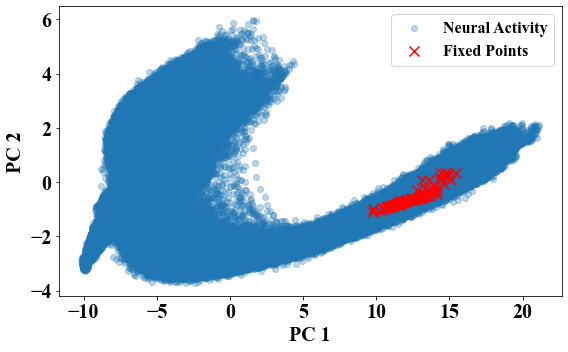

In [ ]:
activity_list = []
for trial_activity in ei_activity_dict.values():
    activity_list.append(trial_activity)  
activity = np.vstack(activity_list)  


fixed_points_array = np.vstack(fixed_points)  

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0) 
pca.fit(activity_and_fp)
print(activity.shape)
print(fixed_points_array.shape)

activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')


plt.xlabel("PC 1", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel("PC 2", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.legend(
    prop={
        'size': 16,  
        'weight': 'bold',
        'family': 'Times New Roman'
    },
    loc='best'  
)

plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task3_plot_fp_PCA.png"
plt.tight_layout()
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 2.07e-01 +/- 5.21e-02
		dq = 5.37e-02 +/- 3.84e-02
		learning rate = 1.97e-07
		avg iter time = 1.19e-03 sec
	Identified 100 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 100).
	Computing recurrent Jacobian at 100 unique fixed points.
	Computing input Jacobian at 100 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.73e-01 +/- 3.99e-02
		dq = 3.93e-02 +/- 3.21

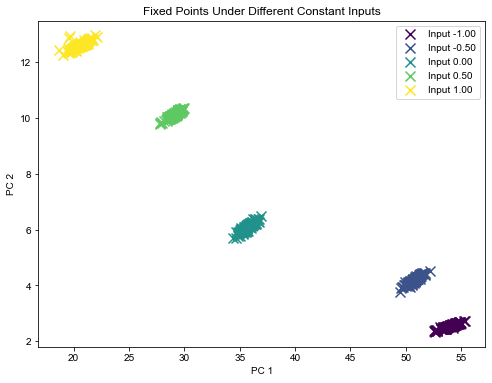

In [ ]:

input_values = np.linspace(-1, 1, 5)  
fixed_points_by_input = []

for input_val in input_values:

    inputs_np = np.full((100, EI_RNN.base_model.input_size), input_val)  

    init_hidden_np = initial_conditions.cpu().numpy()

    fps_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))


plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input): 
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()


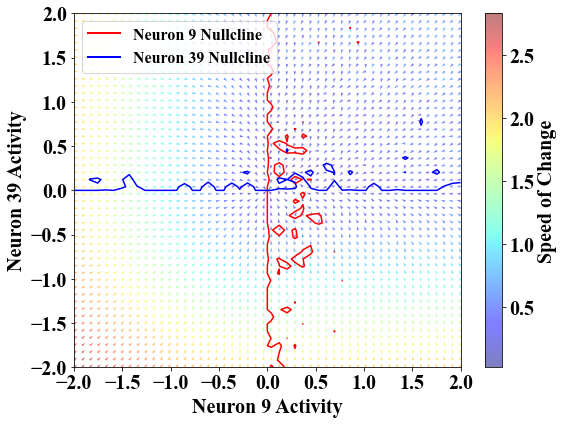

In [ ]:
from matplotlib.lines import Line2D
selectivity_indices = np.argsort(np.abs(selectivity))[-2:]
neuron1, neuron2 = selectivity_indices

n_points = 50
state_range = np.linspace(-2, 2, n_points)
neuron1_states, neuron2_states = np.meshgrid(state_range, state_range)

grid_states = np.c_[neuron1_states.ravel(), neuron2_states.ravel()]


inputs = torch.zeros(grid_states.shape[0], EI_RNN.base_model.input_size).type(torch.float32)

initial_states = np.zeros((grid_states.shape[0], EI_RNN.base_model.rnn.hidden_size))
initial_states[:, neuron1] = grid_states[:, 0]
initial_states[:, neuron2] = grid_states[:, 1]


initial_states_tensor = torch.from_numpy(initial_states).type(torch.float32)


_, next_states = EI_RNN.base_model.rnn(inputs.unsqueeze(0), initial_states_tensor)
next_states = next_states.detach().cpu().numpy()


d_neuron1 = next_states[:, neuron1] - initial_states[:, neuron1]
d_neuron2 = next_states[:, neuron2] - initial_states[:, neuron2]


d_neuron1_grid = d_neuron1.reshape(neuron1_states.shape)
d_neuron2_grid = d_neuron2.reshape(neuron2_states.shape)

U = d_neuron1_grid  
V = d_neuron2_grid  

speed = np.sqrt(U**2 + V**2)
U_norm = U / speed
V_norm = V / speed

plt.figure(figsize=(8, 6))
plt.contour(neuron1_states, neuron2_states, d_neuron1_grid, levels=[0], colors='red')
plt.contour(neuron1_states, neuron2_states, d_neuron2_grid, levels=[0], colors='blue')
quiver = plt.quiver(neuron1_states, neuron2_states, U_norm, V_norm, speed, cmap='jet', alpha=0.5)

# Legend entries
legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Neuron {neuron1} Nullcline'),
                   Line2D([0], [0], color='blue', lw=2, label=f'Neuron {neuron2} Nullcline')]

plt.legend(
    handles=legend_elements,
    loc='upper left', 
    prop={
        'size': 16,  
        'weight': 'bold',
        'family': 'Times New Roman'
    }
)


plt.xlabel(f'Neuron {neuron1} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel(f'Neuron {neuron2} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
#plt.title('Nullclines and Vector Fields', fontsize=14, fontweight='bold', fontfamily='Times New Roman')

plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')

cbar = plt.colorbar(quiver)
cbar.set_label('Speed of Change', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
cbar.ax.tick_params(labelsize=20)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontfamily('Times New Roman')

#save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task2_plot_nuclines.png"
plt.tight_layout()
#plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()

In [65]:
print(neuron1, neuron2)
print(selectivity)

9 39
[-0.38509807  0.3559157  -1.3592205   0.648933   -1.4450252  -1.2356656
 -1.1541867   1.3359829  -0.516943   -1.4629418   0.47017062  1.3707185
  1.0204693  -1.0322481  -1.1400781  -0.01317056 -0.16356055  0.7147953
 -0.2573018   1.3350016  -1.0449985   0.9084165   1.0116607  -0.49429598
  1.3656259  -1.4380364  -1.2516658   0.947101    0.918706    1.0335228
 -1.3861547   0.07407428  0.9157789   0.04593034  0.9846918  -0.05557466
  1.4186236  -1.2574782  -0.38304308  1.5089188  -0.10572703  0.58327866
 -0.93185997  0.2299232  -1.3694215  -0.7488291   0.73882335 -1.3363615
  1.3064699   0.05588249]


For Leaky RNN

In [ ]:
#for leaky RNN lession
e_size_Leaky_RNN = Leaky_RNN.base_model.e_size  

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(leaky_stim_activity[ground_truth], axis=0)
    print(activity.shape)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:]) + e_size))

# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * Leaky_RNN.base_model.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

def lesion_network(net, selective_neurons):
    with torch.no_grad():  
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0

initial_weights = Leaky_RNN.base_model.rnn.h2h.weight.clone()

lesion_network(Leaky_RNN.base_model, selective_neurons)

loss_values_lesioned = []  
running_loss_lesioned = 0.0

print('Evaluating Leaky_RNN after lesioning top 20% of neurons...')
for i in range(300): 
    inputs, labels = dataset()  
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer_Leaky_RNN.zero_grad()

    # Forward pass
    output, activity,_ = Leaky_RNN(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)  

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1):  
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)
        running_loss_lesioned = 0.0

Leaky_RNN.base_model.rnn.h2h.weight = nn.Parameter(initial_weights)

(61300, 50)
(63700, 50)
Evaluating Leaky_RNN after lesioning top 20% of neurons...
Step 2, Lesioned Network Loss 0.5081
Step 4, Lesioned Network Loss 0.3916
Step 6, Lesioned Network Loss 0.6928
Step 8, Lesioned Network Loss 0.5207
Step 10, Lesioned Network Loss 0.7010
Step 12, Lesioned Network Loss 0.2394
Step 14, Lesioned Network Loss 0.4743
Step 16, Lesioned Network Loss 0.6006
Step 18, Lesioned Network Loss 0.6831
Step 20, Lesioned Network Loss 0.5856
Step 22, Lesioned Network Loss 0.4746
Step 24, Lesioned Network Loss 0.6725
Step 26, Lesioned Network Loss 0.3046
Step 28, Lesioned Network Loss 0.5380
Step 30, Lesioned Network Loss 0.8471
Step 32, Lesioned Network Loss 0.4582
Step 34, Lesioned Network Loss 0.3910
Step 36, Lesioned Network Loss 0.3964
Step 38, Lesioned Network Loss 0.2947
Step 40, Lesioned Network Loss 0.5730
Step 42, Lesioned Network Loss 0.3908
Step 44, Lesioned Network Loss 0.4360
Step 46, Lesioned Network Loss 0.6193
Step 48, Lesioned Network Loss 0.6735
Step 50, 

In [ ]:
#do it for the leaky RNN

Leaky_rnn_model_fixed_point = FixedPointRNNWrapper(Leaky_RNN.base_model.rnn, batch_first=False)

leaky_finder = FixedPointFinder(Leaky_rnn_model_fixed_point) 

initial_conditions = torch.randn(100, Leaky_RNN.base_model.rnn.hidden_size) 
print(initial_conditions.shape)
inputs = torch.zeros(100, Leaky_RNN.base_model.rnn.input_size)  
print(inputs.shape)

init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

fixed_points_result = leaky_finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

fps = fixed_points_result[0]  

fixed_points = fps.xstar 




torch.Size([100, 50])
torch.Size([100, 3])

Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		1067 iters
		q = 8.00e-14 +/- 1.36e-13
		dq = 3.10e-14 +/- 3.86e-14
		learning rate = 8.97e-02
		avg iter time = 9.54e-04 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



In [ ]:
print((fps.J_xstar).shape)
aaa = fps.J_xstar
stability_results = []
for i, J in enumerate(aaa):
    eigenvalues = np.linalg.eigvals(J)
    stable = np.all(np.abs(eigenvalues) < 1) 
    stability_results.append((i + 1, eigenvalues, "Stable" if stable else "Unstable"))

#print(stability_results)

import pandas as pd
stability_df = pd.DataFrame(stability_results, columns=["Fixed Point", "Eigenvalues", "Stability"])
print(stability_df)

(1, 50, 50)
   Fixed Point                                        Eigenvalues Stability
0            1  [(0.64786017+0.37066904j), (0.64786017-0.37066...    Stable


(1, 50)
(1015770, 50)
(1, 50)


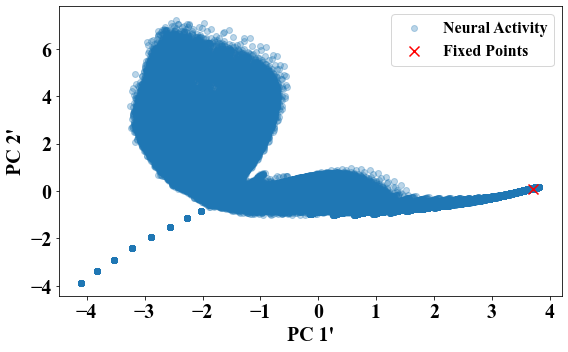

In [ ]:
activity_list = []
for trial_activity in leaky_activity_dict.values():
    activity_list.append(trial_activity) 
activity = np.vstack(activity_list)  

fixed_points_array = np.vstack(fixed_points)  

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0) 

print(fixed_points_array.shape)

pca.fit(activity_and_fp)
print(activity.shape)
print(fixed_points_array.shape)

activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')


plt.xlabel("PC 1'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel("PC 2'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.legend(
    prop={
        'size': 16,
        'weight': 'bold',
        'family': 'Times New Roman'
    },
    loc='best'
)


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task3_plot_fp_PCA.png"
plt.tight_layout()
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		747 iters
		q = 4.80e-13 +/- 2.06e-13
		dq = 1.39e-13 +/- 1.18e-13
		learning rate = 1.50e-01
		avg iter time = 1.03e-03 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		1153 iters
		q = 4.78e-13 +/- 1.68e-13
		dq = 1.63e-13 +/- 1.29e-13
		learni

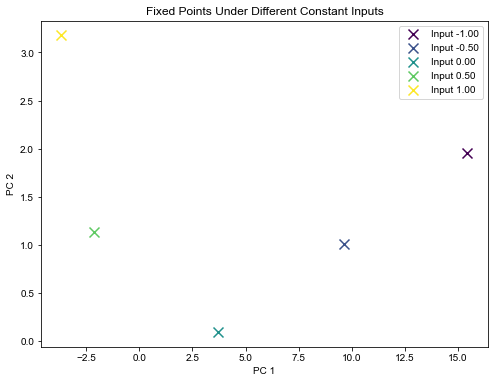

In [ ]:

input_values = np.linspace(-1, 1, 5)  
fixed_points_by_input = []

for input_val in input_values:

    inputs_np = np.full((100, EI_RNN.base_model.input_size), input_val) 

    init_hidden_np = initial_conditions.cpu().numpy()

    fps_result = leaky_finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))

plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input): 
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()

(array([-6., -4., -2.,  0.,  2.,  4.,  6.,  8.]),
 [Text(0, -6.0, '−6'),
  Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8')])

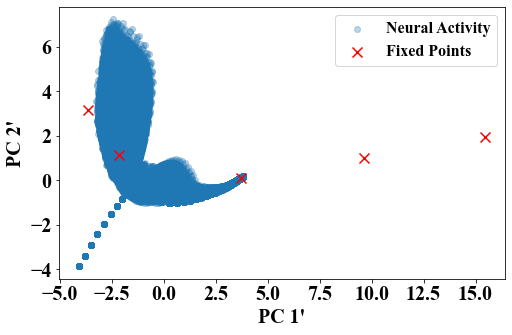

In [71]:
fixed_point_matrices = [np.array(item[1]) for item in fixed_points_by_input]
fixed_point_matrices = np.array(fixed_point_matrices).squeeze()
fixed_point_matrices.shape

new_activity_and_fp = np.concatenate([activity, fixed_point_matrices], axis=0)

new_activity_and_fp.shape

new_pca = PCA(n_components=2)

new_pca.fit(new_activity_and_fp)

new_activity_pc = new_pca.transform(activity)
new_fixed_points_pc = new_pca.transform(fixed_point_matrices)

plt.figure(figsize=(8, 5))
plt.scatter(new_activity_pc[:, 0], new_activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(new_fixed_points_pc[:, 0], new_fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')


plt.xlabel("PC 1'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel("PC 2'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.legend(
    prop={
        'size': 16,
        'weight': 'bold',
        'family': 'Times New Roman'
    },
    loc='best'
)


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')


(array([-6., -4., -2.,  0.,  2.,  4.,  6.,  8.]),
 [Text(0, -6.0, '−6'),
  Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8')])

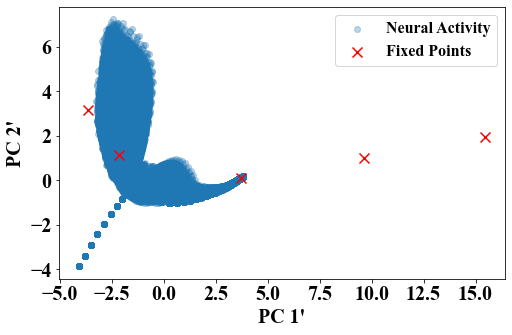

In [72]:

new_activity_and_fp = np.concatenate([activity, fixed_point_matrices], axis=0)

pca.fit(new_activity_and_fp)
#print(activity.shape)
#print(fixed_point_matrices.shape)

new_activity_pc = pca.transform(activity)
new_fixed_points_pc = pca.transform(fixed_point_matrices)

plt.figure(figsize=(8, 5))
plt.scatter(new_activity_pc[:, 0], new_activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(new_fixed_points_pc[:, 0], new_fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')


plt.xlabel("PC 1'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel("PC 2'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.legend(
    prop={
        'size': 16,
        'weight': 'bold',
        'family': 'Times New Roman'
    },
    loc='best'
)


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')


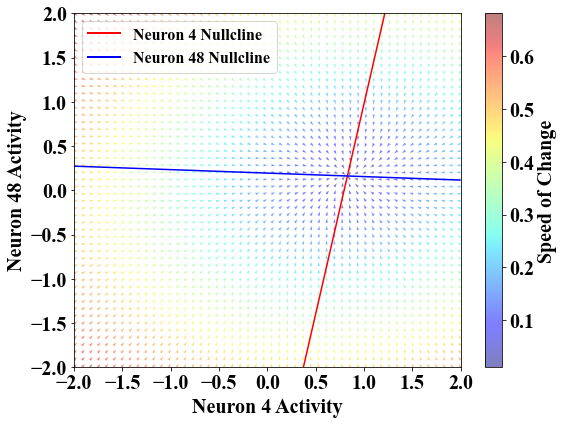

In [73]:
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

selectivity_indices = np.argsort(np.abs(selectivity))[-2:]
neuron1, neuron2 = selectivity_indices

n_points = 50
state_range = np.linspace(-2, 2, n_points)
neuron1_states, neuron2_states = np.meshgrid(state_range, state_range)

grid_states = np.c_[neuron1_states.ravel(), neuron2_states.ravel()]

inputs = torch.zeros(grid_states.shape[0], EI_RNN.base_model.input_size).type(torch.float32)


initial_states = np.zeros((grid_states.shape[0], EI_RNN.base_model.rnn.hidden_size))
initial_states[:, neuron1] = grid_states[:, 0]
initial_states[:, neuron2] = grid_states[:, 1]


initial_states_tensor = torch.from_numpy(initial_states).type(torch.float32)


_, next_states = Leaky_RNN.base_model.rnn(inputs.unsqueeze(0), initial_states_tensor)
next_states = next_states.detach().cpu().numpy()


d_neuron1 = next_states[:, neuron1] - initial_states[:, neuron1]
d_neuron2 = next_states[:, neuron2] - initial_states[:, neuron2]


d_neuron1_grid = d_neuron1.reshape(neuron1_states.shape)
d_neuron2_grid = d_neuron2.reshape(neuron2_states.shape)


U = d_neuron1_grid  
V = d_neuron2_grid  

speed = np.sqrt(U**2 + V**2)
U_norm = U / speed
V_norm = V / speed


plt.figure(figsize=(8, 6))
plt.contour(neuron1_states, neuron2_states, d_neuron1_grid, levels=[0], colors='red')
plt.contour(neuron1_states, neuron2_states, d_neuron2_grid, levels=[0], colors='blue')
quiver = plt.quiver(neuron1_states, neuron2_states, U_norm, V_norm, speed, cmap='jet', alpha=0.5)


legend_elements = [
    Line2D([0], [0], color='red', lw=2, label=f'Neuron {neuron1} Nullcline'),
    Line2D([0], [0], color='blue', lw=2, label=f'Neuron {neuron2} Nullcline')
]


plt.legend(
    handles=legend_elements,
    loc='upper left',
    prop={
        'size': 16,  
        'weight': 'bold',
        'family': 'Times New Roman'
    }
)


plt.xlabel(f'Neuron {neuron1} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel(f'Neuron {neuron2} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')


cbar = plt.colorbar(quiver)
cbar.set_label('Speed of Change', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
cbar.ax.tick_params(labelsize=20)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontfamily('Times New Roman')

#save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task2_plot_nuclines.png"
plt.tight_layout()
#plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()

In [74]:
print(neuron1, neuron2)
print(selectivity)

4 48
[ 4.9204022e-01  1.3966202e+00  0.0000000e+00  7.8072399e-01
  1.7446187e+00 -1.2991791e+00 -1.2567401e+00  1.1383456e-05
  1.6192219e+00  1.3726544e+00  1.5470068e+00  1.4612892e+00
  1.2875681e+00  1.2079893e+00  1.7200558e+00  0.0000000e+00
  1.2923168e+00  1.5990194e+00 -7.2909784e-01  1.6428190e+00
 -9.0591356e-02 -1.4939108e+00 -7.0797849e-01  0.0000000e+00
  0.0000000e+00  1.4461213e+00  1.5484384e-02  1.5836461e+00
  0.0000000e+00 -1.3008634e+00  7.1168911e-01 -8.2502162e-01
 -1.4396558e+00 -6.4640868e-01 -3.8023263e-01 -1.4431387e+00
  5.7593650e-01 -1.4005870e+00 -1.4579200e+00 -1.3879560e-01
  2.9086423e-01 -1.3337640e+00 -2.6258957e-01 -1.4541279e+00
  0.0000000e+00 -2.3772766e-01 -1.5791284e+00  0.0000000e+00
  1.7761176e+00  0.0000000e+00]
